## 테스트 시나리오
1. 모듈 활용 배경 및 가명처리 대상 시나리오
- 에코마케팅 김모 마케터는 신한카드에서 고객 데이터를 사와서 마케팅 연구 용도로 사용하려고 한다.
- 이 과정에서 고객 데이터 중 유독 재식별 가능성이 높은 컬럼들을 골라서 가명처리를 하려고 한다.
- 가명처리 대상: DATA_FINANCE 중 INCOME_BRACKET(소득분위), CREDIT_SCORE(신용평점), AMT_CREDITCARD_PAYMENT(신용카드 결제액), AMT_CREDITLOAN(카드론 액수) 컬럼
- 가명처리 대상 2. DATA_RETAIL 중 AMT_PURCHASES_BOOKS, AMT_PURCHASES_CULTURE, AMT_PURCHASES_EDU
2. 모듈 적용 절차
- 테이블에서 분류 지표가 될만한 컬럼들을 가지고 동질집합을 만든뒤, 그 동질집합을 기반으로 가명처리 모듈, 프라이버시 보호모델 모듈을 적용시킨다
- 그 이후 성과지표가 어느 정도로 나오는지를 알아본다
- 가명처리된 결과물을 갖고
-> 결과물 데이터프레임을 DB에 넣은 뒤
-> 결합모듈로 결합을 수행한 뒤 결합된 데이터 + 결합못한 데이터를 합쳐 DB에 저장 (합칠때, 결합된건지 아닌건지 식별 해줘야함)

## 모듈 불러오기

In [1]:
import re

from prettytable import PrettyTable
import pandas as pd
pd.options.display.float_format = '{:.30f}'.format
import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append("/Users/minjoo/codeStudy/psudonymizerTeam/pseudonymizer")

## 가명처리

### 데이터 불러오기

In [3]:
from pseudonymizer.encryptionPseudonyms.pyMySQLQuery import *

In [4]:
queryObject = PyMySQLQuery(pw = "1234")

In [5]:
queryObject.connectDatabase(
    serverIP = "localhost", 
    port_num = 3306, 
    user_name = "root", 
    database_name = "FINANCIALCONSUMER", 
    kr_encoder = "utf8")
SQL = "SELECT * FROM DATA_FINANCE"
queryObject.dataQueryLanguage(sql = SQL)

In [6]:
DATA_FINANCE_TABLE = queryObject.executeQueryAsDataFrame()

In [7]:
DATA_FINANCE_TABLE["REPAYMENT_RISK_INDEX"].describe()

count   95000.000000000000000000000000000000
mean       49.930178947368418107544130180031
std        29.133233080242330714781928691082
min         0.000000000000000000000000000000
25%        25.000000000000000000000000000000
50%        50.000000000000000000000000000000
75%        75.000000000000000000000000000000
max       100.000000000000000000000000000000
Name: REPAYMENT_RISK_INDEX, dtype: float64

In [8]:
queryObject2 = PyMySQLQuery(pw = "1234")
queryObject2.connectDatabase(
    serverIP = "localhost", 
    port_num = 3306, 
    user_name = "root", 
    database_name = "FINANCIALCONSUMER", 
    kr_encoder = "utf8")
SQL2 = "SELECT * FROM DATA_RETAIL"
queryObject2.dataQueryLanguage(sql = SQL2)

In [9]:
DATA_RETAIL_TABLE = queryObject2.executeQueryAsDataFrame()

In [10]:
DATA_FINANCE_TABLE.info()
DATA_FINANCE_TABLE.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   NUM_SERIAL                  95000 non-null  int64 
 1   NAME                        95000 non-null  object
 2   GENDER                      95000 non-null  object
 3   AGE                         95000 non-null  int64 
 4   PHONE_NUMBER                95000 non-null  object
 5   ZIP_CODE                    95000 non-null  int64 
 6   HOME_ADDRESS                95000 non-null  object
 7   HOME_TYPE                   95000 non-null  object
 8   INCOME_BRACKET              95000 non-null  int64 
 9   CREDIT_SCORE                95000 non-null  int64 
 10  REPAYMENT_RISK_INDEX        95000 non-null  int64 
 11  AMT_CREDITCARD_PAYMENT      95000 non-null  int64 
 12  AMT_CASHADVANCE_PAYMENT     95000 non-null  int64 
 13  NUM_CREDITCARD_ISSUANCES    95000 non-null  in

,NUM_SERIAL,NAME,GENDER,AGE,PHONE_NUMBER,ZIP_CODE,HOME_ADDRESS,HOME_TYPE,INCOME_BRACKET,CREDIT_SCORE,REPAYMENT_RISK_INDEX,AMT_CREDITCARD_PAYMENT,AMT_CASHADVANCE_PAYMENT,NUM_CREDITCARD_ISSUANCES,NUM_CREDITCARD_CANCELED,TF_LOAN,AMT_CREDITLOAN,AMT_CREDITLOAN_OUTSTANDING,TF_PENSION,AMT_PENSION
0,0,강현심,female,80,010-1826-4535,27218,충청북도 제천시 수산면 옥순봉로6길 61-32,"판잣집, 비닐하우스",6,441,61,5357418,8583708,3,5,N,0,0,N,0
1,1,서삼봉,female,30,010-1765-1467,12736,경기도 광주시 초월읍 도곡길 109-9,다세대주택,8,515,10,8870904,5328233,3,1,N,0,0,N,0
2,2,팽상아,female,53,010-6593-5091,51292,경상남도 창원시 마산회원구 회원남32길 28-1(회원동),"판잣집, 비닐하우스",1,269,17,8525658,2005663,6,5,N,0,0,N,0
3,3,박옥점,female,26,010-7714-1345,58541,전라남도 무안군 청계면 구로길 65,다가구 단독주택,7,254,10,2593007,8944424,4,1,N,0,0,N,0
4,4,윤경념,female,69,010-5360-6014,31741,충청남도 당진시 신평면 신평길 64-6,영업 겸용 단독주택,8,590,79,411525,5125357,5,3,N,0,0,N,0


In [11]:
DATA_RETAIL_TABLE.info()
# DATA_FINANCE_TABLE.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NUM_SERIAL                 85000 non-null  int64 
 1   NAME                       85000 non-null  object
 2   GENDER                     85000 non-null  object
 3   AGE                        85000 non-null  int64 
 4   JOIN_DATE                  85000 non-null  object
 5   PHONE_NUMBER               85000 non-null  object
 6   ZIP_CODE                   85000 non-null  int64 
 7   SHIPPING_ADDRESS           85000 non-null  object
 8   NUM_PURCHASES_BOOKS        85000 non-null  int64 
 9   AMT_PURCHASES_BOOKS        85000 non-null  int64 
 10  NUM_PURCHASES_CULTURE      85000 non-null  int64 
 11  AMT_PURCHASES_CULTURE      85000 non-null  int64 
 12  NUM_PURCHASES_EDU          85000 non-null  int64 
 13  AMT_PURCHASES_EDU          85000 non-null  int64 
 14  AMT_US

### DATA_FINANCE 가명처리
- 가명처리 대상: DATA_FINANCE 중 INCOME_BRACKET(소득분위), CREDIT_SCORE(신용평점), AMT_CREDITCARD_PAYMENT(신용카드 결제액), AMT_CREDITLOAN(카드론 액수) 컬럼
- 가명처리 방법
    - NAME : MaskingPseudonymizer(data_type="name")
    - HOME_ADDRESS : MaskingPseudonymizer(data_type="")
    - EMAIL : MaskingPseudonymizer(data_type="email")
    - PHONE_NUMBER : MaskingPseudonymizer(data_type="phone_number")
    - INCOME_BRACKET
        - CategorizationOfNumeric("user_definition", category_mapping={"1~3분위": (1, 3), "4분위": (4, 4), "5분위": (5, 5), "6분위": (6, 6), "7분위": (7, 7), "8~10분위": (8, 10)})
    - CREDIT_SCORE : 
        - 수동: CategorizationOfNumeric("user_definition", category_mapping={"저신용평점": (0, 600), "중신용평점": (600, 900), "고신용평점": (900, 1000)})
        - 자동 : CategorizationOfColumn("bin", grouping_standard=["저신용평점", "중신용평점", "고신용평점"], right=True, ascending=True)
    - REPAYMENT_RISK_INDEX :
        - CategorizationOfColumn("pct", grouping_standard=5, right=False, ascending=True)
    - AMT_CREDITCARD_PAYMENT :
        - TopandBottomCoding(outlier_type="Pct")
        - KLT 적용 이후 MicroAggregation() 적용
        - RandomRoundingPseudonymizer(rounding_type="custom_round")
    - AMT_CREDITLOAN (신용대출) : 
        - TopandBottomCoding(outlier_type="IQR")
        - KLT 적용 이후 MicroAggregation() 적용
- 동질집합: [TF_LOAN, TF_PENSION, NUM_CREDITCARD_ISSUANCES]

In [ ]:
# 테스트
address_masker = AddressMaskingModule("시군구")
masked_address = address_masker.pseudonymizeData("서울특별시 강남구 역삼동")
print("마스킹된 주소:", masked_address)

In [12]:
from pseudonymizer.pseudonym import Pseudonym
from pseudonymizer.pseudonymizers.numcategorization import CategorizationOfNumeric
from pseudonymizer.pseudonymizers.topandBottomCoding import TopandBottomCoding
from pseudonymizer.pseudonymizers.columncategorization import CategorizationOfColumn
from pseudonymizer.pseudonymizers.microAggregation import MicroAggregation
from pseudonymizer.pseudonymizers.maskingPseudonymizer import MaskingPseudonymizer

In [13]:
from pseudonymizer.privacyPreservingModels import PrivacyPreservingModel

In [25]:
name_pseudo = MaskingPseudonymizer(data_type="name")
home_address_pseudo = MaskingPseudonymizer(data_type="address") # 현재 주소는 주소로 인식 안됨
phone_pseudo = MaskingPseudonymizer(data_type="phone_number")

In [26]:
income_pseudo = CategorizationOfNumeric(numeric_type="user_definition", 
                                        category_mapping={"1~3분위": (1, 3), "4분위": (4, 4), "5분위": (5, 5), 
                                                          "6분위": (6, 6), "7분위": (7, 7), "8~10분위": (8, 10)})
credit_pseudo_user = CategorizationOfNumeric(numeric_type="user_definition",
                                             category_mapping={"저신용평점": (0, 600), "중신용평점": (600, 900), "고신용평점": (900, 1000)})
credit_pseudo_auto = CategorizationOfColumn(numeric_type="bin", grouping_standard=["저신용평점", "중신용평점", "고신용평점"], 
                                            right=True, ascending=True)
repayment_risk_pseudo = CategorizationOfColumn(numeric_type="pct", grouping_standard=5, right=False, ascending=True)

In [27]:
card_pay_pseudo = TopandBottomCoding(outlier_type="Pct", bounded_value=0.1)

In [ ]:
# ppm = PrivacyPreservingModel(dataframe=DATA_FINANCE_TABLE, epsilon=)

In [28]:
credit_loan_pseudo = TopandBottomCoding(outlier_type="IQR", bounded_value=0.1)

In [29]:
pseudonymizer = Pseudonym(dataframe=DATA_FINANCE_TABLE)

In [30]:
pseudonymizer.categorizeEquivalentClass(["TF_LOAN", "TF_PENSION", "NUM_CREDITCARD_ISSUANCES"])

In [31]:
pseudonymizer.addDictionary(column="NAME", pseudonymizers=[name_pseudo])
# pseudonymizer.addDictionary(column="HOME_ADDRESS", pseudonymizers=[home_address_pseudo])
# pseudonymizer.addDictionary(column="PHONE_NUMBER", pseudonymizers=[phone_pseudo])

In [32]:
pseudonymizer.addDictionary(column="INCOME_BRACKET", pseudonymizers=[income_pseudo])
pseudonymizer.addDictionary(column="CREDIT_SCORE", pseudonymizers=[credit_pseudo_user, credit_pseudo_auto])
pseudonymizer.addDictionary(column="REPAYMENT_RISK_INDEX", pseudonymizers=[repayment_risk_pseudo])
pseudonymizer.addDictionary(column="AMT_CREDITCARD_PAYMENT", pseudonymizers=[card_pay_pseudo])
pseudonymizer.addDictionary(column="AMT_CREDITLOAN", pseudonymizers=[credit_loan_pseudo])

In [33]:
pseudonymizer._pseudonymDictionary

{'NAME': [<pseudonymizer.pseudonymizers.maskingPseudonymizer.MaskingPseudonymizer at 0x3030e4a10>],
 'INCOME_BRACKET': [<pseudonymizer.pseudonymizers.numcategorization.CategorizationOfNumeric at 0x303111a50>],
 'CREDIT_SCORE': [<pseudonymizer.pseudonymizers.numcategorization.CategorizationOfNumeric at 0x303111a10>,
 'REPAYMENT_RISK_INDEX': [<pseudonymizer.pseudonymizers.columncategorization.CategorizationOfColumn at 0x17fafc050>],
 'AMT_CREDITCARD_PAYMENT': [<pseudonymizer.pseudonymizers.topandBottomCoding.TopandBottomCoding at 0x17f621990>],
 'AMT_CREDITLOAN': [<pseudonymizer.pseudonymizers.topandBottomCoding.TopandBottomCoding at 0x17fafebd0>]}

- MaskingPseudonymizer name, address, phone number 전부 수정 필요

In [34]:
pseudonymizer.pseudonymizeData()

TypeError: can only concatenate str (not "float") to str

### DATA_RETAIL 가명처리
- AMT_PURCHASES_BOOKS, AMT_PURCHASES_CULTURE, AMT_PURCHASES_EDU
- 차분프라이버시 적용 (라플라스 or 가우시안 하나씩 해보기)
- AMT_PURCHASES_BOOKS -> 가우시안, 나머지 라플라스
- 동질집합: ["AGE", "GENDER"]
- 개인정보 마스킹: NAME, PHONE_NUMBER, ZIP_CODE, SHIPPING_ADDRESS
- JOIN_DATE (날짜 컬럼) -> CategorizationOfNumeric(numeric_type="age", grouping_standard="3bin")

In [35]:
DATA_RETAIL_TABLE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NUM_SERIAL                 85000 non-null  int64 
 1   NAME                       85000 non-null  object
 2   GENDER                     85000 non-null  object
 3   AGE                        85000 non-null  int64 
 4   JOIN_DATE                  85000 non-null  object
 5   PHONE_NUMBER               85000 non-null  object
 6   ZIP_CODE                   85000 non-null  int64 
 7   SHIPPING_ADDRESS           85000 non-null  object
 8   NUM_PURCHASES_BOOKS        85000 non-null  int64 
 9   AMT_PURCHASES_BOOKS        85000 non-null  int64 
 10  NUM_PURCHASES_CULTURE      85000 non-null  int64 
 11  AMT_PURCHASES_CULTURE      85000 non-null  int64 
 12  NUM_PURCHASES_EDU          85000 non-null  int64 
 13  AMT_PURCHASES_EDU          85000 non-null  int64 
 14  AMT_US

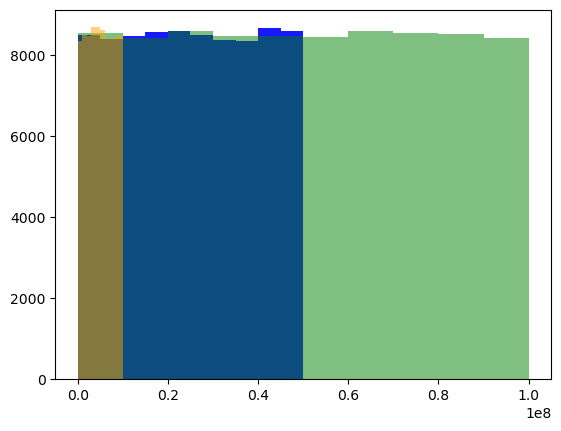

In [36]:
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_EDU"], color = "blue", alpha = 0.9)
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_CULTURE"], color = "green", alpha = 0.5)
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_BOOKS"], color = "orange", alpha = 0.5)
plt.show()

In [37]:
from pseudonymizer.privacyPreservingModels import PrivacyPreservingModel

In [38]:
books_pseudo = PrivacyPreservingModel(dataframe=DATA_RETAIL_TABLE, epsilon=1)

In [ ]:
culture_pseudo = PrivacyPreservingModel()

## 가명결합